# Fisher Information

a collection of methods in order to calculate the fisher matrix

In [1]:
import classy as cl
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import pickle

pi = np.pi

In [36]:
step_sizes = {
    'omega_b': 0.0008,
    'omega_cdm': 0.002,
    '100*theta_s': 0.002,
    'A_s': 1e-10,
    'n_s': 0.01,
    'tau_reio': 0.02
}
cosmo = Class()
cosmo.compute()
h = cosmo.h()
cosmo.struct_cleanup()
cosmo.empty()
print(h)

0.67556


In [3]:
def quick_Pk_zbins(VolGpc, z_bins, k_MAX=0.7, add={'N_ur':3.046}):
    z_string=''
    for elem in z_bins[:-1]:
        z_string+=str(elem)+','
    z_string+=str(z_bins[-1])
    k_MIN_Gpc=2*np.pi/float(VolGpc)**(1/3.)
    k_MIN = k_MIN_Gpc*10**(-3)
    
    k_array = np.arange(k_MIN, k_MAX, k_MIN)
    #define a dictionary with the parameters of desired cosmology
    params = {
        'output': 'tCl pCl lCl mPk',
        'l_max_scalars': 5000,
        'lensing': 'yes',
        'A_s': 2.3e-9,
        'n_s': 0.9624,
        '100*theta_s': 1.042143,
        'omega_b':0.022068,
        'omega_cdm': 0.12029,
        'tau_reio': 0.06
    }
    for key in add.keys():
        params[key] = add[key]
    params['z_pk'] = z_string
    Pk = {}
    wPk = {}
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    h = cosmo.h()
    #there's no xrange in Python3
    for z_k in z_bins:
        Pk[z_k] = np.zeros(len(k_array))
        for i in range(len(k_array)):
            Pk[z_k][i] = cosmo.pk(h*k_array[i], z_k)*h**3
    cosmo.struct_cleanup()
    cosmo.empty()
    return Pk,k_array,params

In [4]:
def derivative(parameters, step_sizes, VolGpc, z_bins, k_MAX):
    """
    Parameters
    ---------
    parameters : dictionary
        contains the values of the parameters that will be used
        to calculate the derivative
    step_sizes : dictionary
        contains the sizes of the steps that will be taken when
        computing the different cosmos.
    VolGpc : number
        the value for the volume of the galaxy survey which will
        be used as a parameter for quick_Pk_zbins
    z_bins : list
        the different bins of the redshift which will be used as
        a parameter for quick_Pk_zbins
    k_MAX : number
        the maximum k value which will be used to calculate the
        power spectrum in quick_Pk_zbins
                
    Returns
    ------
    partials : dictionary
        contains a dictionary of dictionaries where the first
        key value represents the redshift 'z' and then the
        second key value represents the different parameters
        which were stepped over for the derivative; the values
        of the inner dictionary are arrays which are the
        derivatives for the specified ks
    k_array : array
        contains the different k values for the power spectrum
                
    Function used to calculate the numerical derivative:
                f'(param) = (f(param+h)-f(param-h))/(2h)
        where h is the step size of some parameter param
    """
    
    partials = {}
    
    for z in z_bins:
        add = {} #a parameter for quick_Pk_zbins
        partials[z] = {}
        for elem in step_sizes:
            h = step_sizes[elem] #step size, not to be confused with Hubble constant
            add[elem] = parameters[elem] + h
            Pk_1, k_array, params_1 = quick_Pk_zbins(VolGpc, z_bins, k_MAX, add)

            add[elem] = parameters[elem] - h
            Pk_2, k_array, params_2 = quick_Pk_zbins(VolGpc, z_bins, k_MAX, add)
        
            partials[z][elem] = (Pk_1[z] - Pk_2[z])/(2*h)
        #print(partials)
    return partials, k_array

With the derivative function, I want to run it only once as long as the step sizes for the parameters doesn't change. I can do this by pickling the resulting output and then using that in other functions.

The equation used to calculate the fisher matrix is given below:

$$F_{ij} = \int_{k_{min}}^{k_{max}} \frac{dk k^2}{(2\pi)^2} \frac{\partial P(k)}{\partial \theta_i} \frac{\partial P(k)}{\partial \theta_j} V_{eff}(k)$$

where $$V_{eff}(k) \approx \left[ \frac{\bar{n_g}P_g(k)}{\bar{n_g}P_g(k) + 1} \right]^2 V$$

In [45]:
def fisher_information(step_sizes, derivatives, Pk, k_array, z, galaxy_density, VolGpc):
    """
    Parameters
    ---------
    step_sizes : dictionary
        contains the different parameters that we will be
        concerned with
    derivatives : dictionary
        contains the derivatives of the power spectrum with
        respect to the parameters in step_sizes
    Pk : dictionary
        contains the power spectrum for the different
        redshift values
    k_array : list
        all the associated k values in the power spectrum
        derivatives
    z : number
        the redshift value we are concerned with
    galaxy_density : number
        the average number of galaxies per unit volume
    VolGpc : number
        the volume of the survey
                
    Returns
    ------
    fisher : dictionary
        contains more dictionaries inside where each one will
        represent a row in 2D matrix, due to the symmetry of
        matrix, the order of calling row or col should result
        in the same value being returned
    """
    h = 0.67556 #hubble constant
    
    fisher = {} #initialize the fisher matrix (dictionary) to return
    k_min = k_array[0]*h
    
    for row in step_sizes:
        fisher[row] = {}
        for col in step_sizes:
            #print('row: ' + row,'col: ' + col)
            value = 0
            for k in range(len(k_array)):
                V_eff = (1/(Pk[z][k] + 1/galaxy_density))**2*VolGpc*(10**9)*(h**3)
                value += k_min*((k_array[k]*h)**2)/((2*pi)**2)*derivatives[z][row][k]*derivatives[z][col][k]*V_eff
            fisher[row][col] = value
    return fisher

In [6]:
def matrix_maker(pseudo_matrix):
    """
    Parameters
    ---------
    pseudo_matrix : dictionary
        contains keys indicating the index of the row and the
        values are nested dictionaries with their keys
        indicating the index of the column and their values
        being the actual value in the matrix
        
    Returns
    ------
    actual_matrix : matrix
        a numpy matrix
    indices : list
        contains the order of each index of the matrix    
    """
    
    size = len(pseudo_matrix)
    matrix = np.zeros((size, size))
    
    indices = []
    for row, i in zip(pseudo_matrix, range(size)):
        indices.append(row)
        for col, j in zip(pseudo_matrix[row], range(size)):
            matrix[i][j] = pseudo_matrix[row][col]
    actual_matrix = np.matrix(matrix)
    return actual_matrix, indices

In [7]:
def find_sigma(fisher, indices):
    """
    Parameters
    ---------
    fisher : matrix
        a numpy matrix
    indices : list
        contains the order of each index of the matrix
    
    Returns
    ------
    sigma : dictionary
        contains the list of all the parameters and their
        associated error
    """
    
    sigma = {}
    
    cov = fisher.I
    
    for index, i in zip(indices, range(len(fisher))):
        sigma[index] = str((cov.item((i, i)))**(1/2))
        print('Error for ' + index + ' is : ' + sigma[index])
    return sigma

At this point, I think I have defined all the different methods I need in order to calculate the fisher information and find the error associated with the parameters we're concerned with. Moving forward, I will first calculate the derivatives and pickle it for use later, so that I don't have to compute it every time.

## Initial parameters we care about:

In [31]:
step_sizes = {
    'omega_b': 0.0008,
    'omega_cdm': 0.002,
    '100*theta_s': 0.002,
    'A_s': 1e-10,
    'n_s': 0.01,
    'tau_reio': 0.02
}
parameters = {
        'output': 'tCl pCl lCl mPk',
        'l_max_scalars': 5000,
        'lensing': 'yes',
        'A_s': 2.3e-9,
        'n_s': 0.9624,
        '100*theta_s': 1.042143,
        'omega_b':0.022068,
        'omega_cdm': 0.12029,
        'tau_reio': 0.06
}
VolGpc = 200
z_bins = [0] #redshift values
k_MAX = 0.7
z = 0 #choosing redshift of zero
galaxy_density = 10e-2 #number of galaxies in a Megaparsec^3

Here we will calculate the derivatives and save it in case we want to reuse the data later.

In [9]:
# derivatives, k_array = derivative(parameters, step_sizes, VolGpc, z_bins, k_MAX)
# filename = 'dfile'
# outfile = open(filename, 'wb')
# pickle.dump(derivatives, outfile)
# outfile.close()

In [10]:
#print(derivatives)

In [11]:
filename = 'dfile'
infile = open(filename, 'rb')
derivatives = pickle.load(infile)
infile.close()
Pk, k_array, params = quick_Pk_zbins(VolGpc, z_bins, k_MAX)

In [46]:
fisher = fisher_information(step_sizes, derivatives, Pk, k_array, z, galaxy_density, VolGpc)
matrix, indices = matrix_maker(fisher)
#print(matrix)
sigma = find_sigma(matrix, indices)

Error for omega_b is : 0.0011600675169930789
Error for omega_cdm is : 0.0019587107654927354
Error for 100*theta_s is : 0.00153477858698553
Error for A_s is : 1.5749075489056804e-11
Error for n_s is : 0.001702723747091209
Error for tau_reio is : 0.42002525648636957


In [13]:
print(parameters)

{'output': 'tCl pCl lCl mPk', 'l_max_scalars': 5000, 'lensing': 'yes', 'A_s': 2.3e-09, 'n_s': 0.9624, '100*theta_s': 1.042143, 'omega_b': 0.022068, 'omega_cdm': 0.12029, 'tau_reio': 0.06}


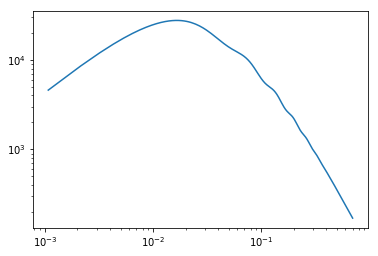

In [49]:
plt.plot(k_array, Pk[0])
plt.xscale('log')
plt.yscale('log')